# Project No. 01 - SMS Classifier

# Name - Kumar Shivam
## Data Science Internship
## Bharat Intern - Jan/2024

### Importing required libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Importing dataset

In [11]:
df = pd.read_csv("C:\\Users\\CODER\\Desktop\\Bharat Intern\\sms_cls\\spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


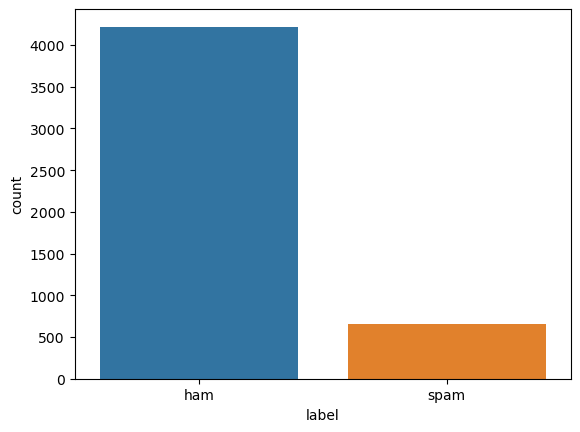

In [13]:
sns.countplot(x=df['label'])
plt.show()

In [14]:
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

16


In [15]:
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)

total_words_length = len(s)
print(total_words_length)

14407


### Splitting the data into Training and Testing sets

In [16]:
from sklearn.model_selection import train_test_split
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3899,), (3899,), (975,), (975,))

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [22]:
from tensorflow.keras.layers import TextVectorization
 
MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len
 
text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [24]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [26]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train 
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, 
    precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1-score': f1}

    return model_results_dict

In [36]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2)
history_2 = fit_model(model_2, epochs=5)

Epoch 1/5
122/122 [==============================] - 26s 125ms/step - loss: 0.0625 - accuracy: 0.9890 - val_loss: 0.0930 - val_accuracy: 0.9836
Epoch 2/5
122/122 [==============================] - 13s 107ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0794 - val_accuracy: 0.9877
Epoch 3/5
122/122 [==============================] - 13s 107ms/step - loss: 1.6335e-04 - accuracy: 1.0000 - val_loss: 0.0802 - val_accuracy: 0.9877
Epoch 4/5
122/122 [==============================] - 13s 107ms/step - loss: 5.5193e-05 - accuracy: 1.0000 - val_loss: 0.0841 - val_accuracy: 0.9877
Epoch 5/5
122/122 [==============================] - 13s 109ms/step - loss: 3.1401e-05 - accuracy: 1.0000 - val_loss: 0.0873 - val_accuracy: 0.9877


In [37]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                            'Custom-Vec-Embedding Model':model_1_results,
                            'Bidirectional-LSTM Model':model_2_results,
                            'USE-Transfer learning Model':model_2_results}).transpose()

total_results

31/31 [==============================] - 2s 15ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.970256,1.000000,0.780303,0.876596
Custom-Vec-Embedding Model,0.939487,0.758865,0.810606,0.783883
Bidirectional-LSTM Model,0.987692,0.976190,0.931818,0.953488
USE-Transfer learning Model,0.987692,0.976190,0.931818,0.953488


In [38]:
models = ['MultinomialNB', 'Custom-Vec-Embedding', 'Bidirectional-LSTM', 'USE-Transfer learning']
accuracy = [0.970256, 0.943590, 0.986667, 0.986667]
precision = [1.000000, 0.987342, 0.954198, 0.954198]
recall = [0.780303, 0.590909, 0.946970, 0.946970]
f1_score = [0.876596, 0.739336, 0.950570, 0.950570]

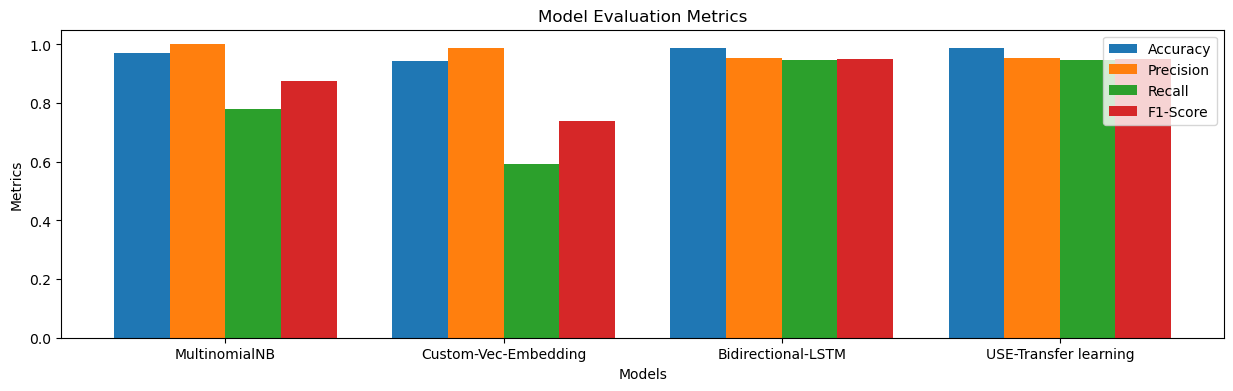

In [39]:
fig, ax = plt.subplots(figsize=(15, 4))
bar_width = 0.2
index = np.arange(len(models))
index_accuracy = index
index_precision = index + bar_width
index_recall = index + 2 * bar_width
index_f1_score = index + 3 * bar_width
plt.bar(index_accuracy, accuracy, width=bar_width, label='Accuracy')
plt.bar(index_precision, precision, width=bar_width, label='Precision')
plt.bar(index_recall, recall, width=bar_width, label='Recall')
plt.bar(index_f1_score, f1_score, width=bar_width, label='F1-Score')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Evaluation Metrics')
plt.xticks(index + 1.5 * bar_width, models)
plt.legend()
plt.show()